In [1]:
# GPU Reset if needed

from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
# from google.colab import drive
import os

# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Colab Notebooks/word2vec_run/')
# print(os.getcwd())

In [3]:
# !ls

In [4]:
# !rm -rf logs

In [5]:
# Import Tensorflow and related libraries

import tensorflow

from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import BatchNormalization


from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D

from tensorflow.keras.layers import Input

from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder

print("TensorFlow version : " + tensorflow.__version__)

import numpy as np
print("Numpy version : " + np.version.version)

import pandas as pd
print("Pandas version : " + pd.__version__)

TensorFlow version : 2.5.0
Numpy version : 1.19.5
Pandas version : 1.1.5


In [6]:
# Display available GPUs

physical_devices = tensorflow.config.list_physical_devices('GPU')
for gpu in physical_devices:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [7]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1060 3GB (UUID: GPU-7e3eed14-c9a0-0a6c-b6f9-798ae952635f)


In [8]:
!nvidia-smi

Thu Sep  2 09:28:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.68       Driver Version: 471.68       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 25%   34C    P5     9W / 120W |    644MiB /  3072MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# Enable Memory Growth

if physical_devices != []:
    tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
    physical_devices[0]

In [10]:
# Parameters

author_list = ['Charles Dickens','Jane Austen','Sir Arthur Conan Doyle','George Eliot','Jules Verne']
seed_number = 122
dataset_file  = "dataset.csv"
validation_dataset_file  = "validation_dataset.csv"

batch_size = 16 # number of images per batch to be processed

epochs = 150 # number of maximum epochs to run

trunc_type = 'post'
padding_type = 'post'

In [11]:
validation_data = pd.read_csv(validation_dataset_file, usecols = ['author','text'])

In [12]:
data = pd.read_csv(dataset_file, usecols = ['author','text'])

In [13]:
data.sample(5)

,author,text
23711,Jules Verne,stations the wire was wound round a magnet tha...
22502,Jules Verne,which by means of a current of electricity wou...
22785,Jules Verne,eye could reach. three hours passed away witho...
1075,Charles Dickens,brace it was not for want of the means of infl...
13135,Sir Arthur Conan Doyle,concerned at the sudden illness of my host to ...


In [14]:
# max_length = max(data["text"].str.len())
# print("Max text length: " + str(max_length))

max_length = 100

In [15]:
# full_text = []
# for record in data["text"]:
#     full_text += record

# unique = set(full_text)
# print(unique)

In [16]:
from sklearn.model_selection import train_test_split

# Train, Test, Validation Spit ratios 60%, 20%, 20% 

X_train, X_val, y_train, y_val = train_test_split(data["text"], data["author"], test_size=0.2, random_state=2000)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=seed_number) # 0.25 x 0.8 = 0.2

In [17]:
len(X_train)

15000

In [18]:
len(X_test)

5000

In [19]:
len(X_val)

5000

In [20]:
validation_data.sample(5)

,author,text
3795,Jules Verne,be long in lowering they redoubled their effor...
3946,Jules Verne,i now recognized as that john turner who had b...
3401,Jules Verne,know the pym family that you have never met th...
2909,George Eliot,from home with good reasons in his pocket year...
1360,Jane Austen,dearest mother the affair which has given us s...


In [21]:
X_val_2 = validation_data.text
y_val_2 = validation_data.author

In [22]:
len(X_val_2)

4000

In [23]:
X_val_2.sample(5)

318     ferret eyes when the chimes of a neighbouring ...
3337    dont stop here urged joe let us go up master l...
886     of this one great deviation from the strict ru...
387     the infection off though the plump sister trie...
2563    by a wave of loving penitence and words burst ...
Name: text, dtype: object

In [24]:
y_val_2.sample(5)

683     Charles Dickens
3398        Jules Verne
1562        Jane Austen
3877        Jules Verne
447     Charles Dickens
Name: author, dtype: object

In [25]:
text_tokenizer = Tokenizer() #num_words = vocab_size, oov_token=oov_tok)
text_tokenizer.fit_on_texts(X_train)
text_index = text_tokenizer.word_index

X_train_sequences = text_tokenizer.texts_to_sequences(X_train)
X_train_sequences = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_sequences = text_tokenizer.texts_to_sequences(X_test)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_val_sequences = text_tokenizer.texts_to_sequences(X_val)
X_val_sequences = pad_sequences(X_val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_val_sequences_2 = text_tokenizer.texts_to_sequences(X_val_2)
X_val_sequences_2 = pad_sequences(X_val_sequences_2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [26]:
vocab_size = len(text_index) + 1
print(vocab_size)

31202


In [27]:
X_train_sequences

array([[  16, 6934,   19, ...,    0,    0,    0],
       [  15,   43,   65, ...,    0,    0,    0],
       [   9,    1, 6300, ...,    0,    0,    0],
       ...,
       [   3,   31,    6, ...,    0,    0,    0],
       [2193,    2, 1027, ...,    0,    0,    0],
       [ 244,   25,   15, ...,    0,    0,    0]])

In [28]:
label_tokenizer = LabelEncoder()
label_tokenizer.fit(author_list)
label_index = label_tokenizer.classes_

y_train_sequences = np.array(label_tokenizer.transform(y_train))
y_test_sequences = np.array(label_tokenizer.transform(y_test))
y_val_sequences = np.array(label_tokenizer.transform(y_val))
y_val_sequences_2 = np.array(label_tokenizer.transform(y_val_2))

In [29]:

# label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(y_train)
# label_index = label_tokenizer.word_index

# y_train_sequences = np.array(label_tokenizer.texts_to_sequences(y_train))
# y_test_sequences = np.array(label_tokenizer.texts_to_sequences(y_test))

In [30]:
label_index

array(['Charles Dickens', 'George Eliot', 'Jane Austen', 'Jules Verne',
       'Sir Arthur Conan Doyle'], dtype='<U22')

In [31]:
vec_size = 250

### Word2Vec vector loading

In [32]:
# Ref : https://tfhub.dev/google/Wiki-words-250/2

In [33]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")


In [34]:
no_vectors = []

In [35]:
%%time

word_vector_matrix = np.zeros((vocab_size, vec_size))

for word, index in text_index.items():
#     print(word,"-->",index)
    vector = embed([word])[0].numpy()
  
    if vector is not None:
        word_vector_matrix[index] = vector
    if (not np.any((vector))) or (vector is None):
        no_vectors.append(word) 

Wall time: 1min 5s


In [36]:
# text_index

In [37]:
np.savetxt("word_vector_matrix.csv", word_vector_matrix, delimiter=",")

In [38]:
len(no_vectors)

8711

In [39]:
len(word_vector_matrix)

31202

In [40]:
vocab_size

31202

In [41]:
# if text_index.get(word) != None:
#     print("yes")
# else:
#     print("no")    

In [42]:
# word_vector_matrix[0]

Model: "keras_word2vec_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 250)          7800500   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 250)          501000    
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 250)          1000      
_________________________________________________________________
dropout (Dropout)            (None, 100, 250)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 250)          501000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 250)          1000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 250)  

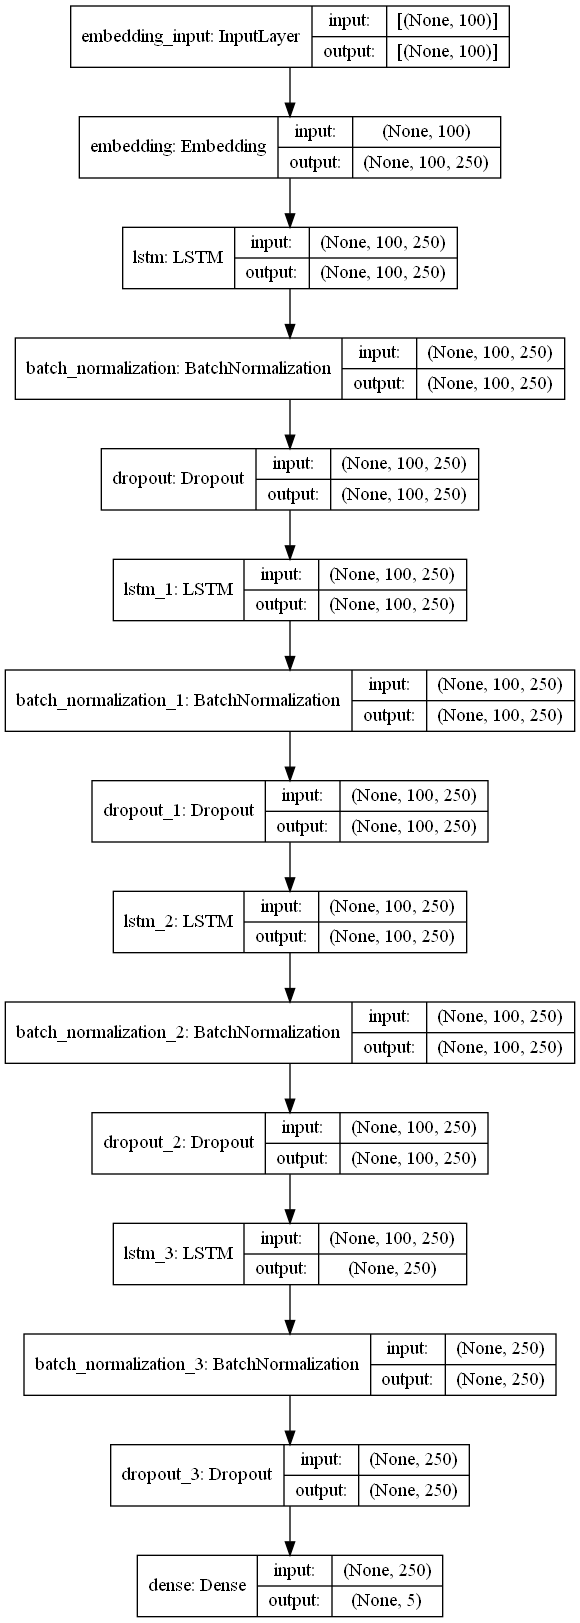

In [43]:
# define new model

# Testing model based on "https://medium.com/voice-tech-podcast/an-overview-of-rnn-lstm-gru-79ed642751c6"

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length = max_length, weights = [word_vector_matrix], trainable = False))

#model.add(BatchNormalization())
model.add(LSTM(units=vec_size, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(units=vec_size, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(units=vec_size, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(units=vec_size))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(GRU(units=vec_size, return_sequences=False))

#model.add(LSTM(units=vec_size, ))

#model.add(TimeDistributed(Dense(vocab_size)))

#model.add(Conv1D(64, 8, activation = 'relu'))
#model.add(MaxPooling1D(2))
# model.add(Dropout(0.3))

# model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(0.3))          
    
# model.add(Dense(16, activation = 'relu'))
          
#model.add(GlobalMaxPooling1D())          
          
# #model.add(LSTM(64,dropout=0.3)) # , recurrent_dropout =0.3))
model.add(Dense(5, activation='softmax'))

model._name = "keras_word2vec_lstm"
model.summary()

# Save the model as a png file
plot_model(model, to_file=model._name +'.png', show_shapes=True, show_layer_names=True)

In [44]:
# Show the trainable status of the layers

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 embedding False
1 lstm True
2 batch_normalization True
3 dropout True
4 lstm_1 True
5 batch_normalization_1 True
6 dropout_1 True
7 lstm_2 True
8 batch_normalization_2 True
9 dropout_2 True
10 lstm_3 True
11 batch_normalization_3 True
12 dropout_3 True
13 dense True


In [45]:
# Compile the model

model.compile(
    #optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
    optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [46]:
# Tensorboard parameters

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [47]:
# Use best weights for the model

early_stopping_monitor = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

In [48]:
# Training the model

model.fit(
    X_train_sequences, y_train_sequences, epochs=epochs, batch_size = batch_size,shuffle = True, callbacks=[early_stopping_monitor, tensorboard_callback], validation_data=(X_test_sequences , y_test_sequences ),
    )


Epoch 1/150
938/938 [==============================] - 82s 79ms/step - loss: 2.5022 - accuracy: 0.1960 - val_loss: 3.5901 - val_accuracy: 0.2054
Epoch 2/150
938/938 [==============================] - 72s 77ms/step - loss: 2.0018 - accuracy: 0.2784 - val_loss: 2.2944 - val_accuracy: 0.3272
Epoch 3/150
938/938 [==============================] - 72s 77ms/step - loss: 1.7716 - accuracy: 0.3199 - val_loss: 1.6474 - val_accuracy: 0.3070
Epoch 4/150
938/938 [==============================] - 72s 77ms/step - loss: 1.6296 - accuracy: 0.3337 - val_loss: 2.0568 - val_accuracy: 0.2418
Epoch 5/150
938/938 [==============================] - 72s 77ms/step - loss: 1.5367 - accuracy: 0.3457 - val_loss: 6.7669 - val_accuracy: 0.1988
Epoch 6/150
938/938 [==============================] - 72s 76ms/step - loss: 1.4760 - accuracy: 0.3627 - val_loss: 2.7974 - val_accuracy: 0.2398
Epoch 7/150
938/938 [==============================] - 72s 77ms/step - loss: 1.4383 - accuracy: 0.3836 - val_loss: 1.5720 - val_ac

938/938 [==============================] - 72s 77ms/step - loss: 0.3243 - accuracy: 0.8877 - val_loss: 1.1265 - val_accuracy: 0.6840
Epoch 57/150
938/938 [==============================] - 73s 78ms/step - loss: 0.3087 - accuracy: 0.8937 - val_loss: 1.0938 - val_accuracy: 0.7028
Epoch 58/150
938/938 [==============================] - 72s 77ms/step - loss: 0.2937 - accuracy: 0.9009 - val_loss: 1.2873 - val_accuracy: 0.6748
Epoch 59/150
938/938 [==============================] - 77s 82ms/step - loss: 0.2878 - accuracy: 0.9036 - val_loss: 1.1525 - val_accuracy: 0.6914
Epoch 60/150
938/938 [==============================] - 73s 77ms/step - loss: 0.2746 - accuracy: 0.9071 - val_loss: 1.1713 - val_accuracy: 0.7058
Epoch 61/150
938/938 [==============================] - 72s 77ms/step - loss: 0.2582 - accuracy: 0.9115 - val_loss: 1.2408 - val_accuracy: 0.6870
Epoch 62/150
938/938 [==============================] - 72s 77ms/step - loss: 0.2406 - accuracy: 0.9194 - val_loss: 1.5129 - val_accuracy

In [49]:
# Show tensorboard

%load_ext tensorboard
%tensorboard --logdir logs/fit
#%reload_ext tensorboard # just in case tensorboard didn't refresh


Reusing TensorBoard on port 6006 (pid 8588), started 12:43:22 ago. (Use '!kill 8588' to kill it.)

In [50]:
# Function to generate accuracy report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def accuracy_report(X_val_sequences,y_val_sequences):
    # Calculate preditions for the validation dataset

    # import numpy as np

    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    y_pred = model.predict_classes([X_val_sequences])
    len(y_pred)

    y_true= y_val_sequences
    len(y_pred)
    
    print(y_pred)

    # for image_batch, label_batch in val_ds:
    #     y_true.append(label_batch)
    #     preds = model.predict(image_batch)
    #     y_pred.append(np.argmax(preds, axis = - 1))

    # # Convert the true and predicted labels into tensors
    true_categories = label_tokenizer.inverse_transform(y_true)#tensorflow.concat([item for item in y_true], axis = 0)
    predicted_categories = label_tokenizer.inverse_transform(y_pred)#np.argmax(y_pred, axis = - 1)) #tensorflow.concat([item for item in y_pred], axis = 0)

    print(predicted_categories)

    # Generate confusion matrix

    cnf_matrix = confusion_matrix(true_categories,predicted_categories,  normalize='pred')

    # Plot confusion matrix



    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                                  display_labels=label_index)

    disp = disp.plot(cmap='Blues', xticks_rotation=45)

    plt.show()



    print("Accuracy for validation split: " ,accuracy_score(y_true, y_pred))

D:\Miniconda\envs\tf2_old\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[3 0 3 ... 0 2 1]
['Jules Verne' 'Charles Dickens' 'Jules Verne' ... 'Charles Dickens'
 'Jane Austen' 'George Eliot']


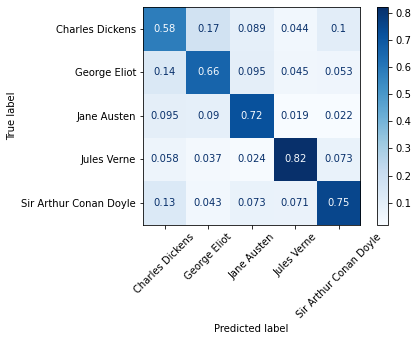

Accuracy for validation split:  0.7062


In [51]:
# accuracy_report for same books

accuracy_report(X_val_sequences,y_val_sequences)

D:\Miniconda\envs\tf2_old\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0 4 2 ... 0 3 3]
['Charles Dickens' 'Sir Arthur Conan Doyle' 'Jane Austen' ...
 'Charles Dickens' 'Jules Verne' 'Jules Verne']


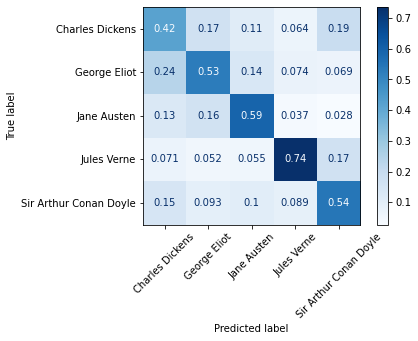

Accuracy for validation split:  0.55575


In [52]:
# accuracy_report for seperate books

accuracy_report(X_val_sequences_2,y_val_sequences_2)

In [53]:
# Saving final model for future use

model.save(model._name + ".h5")